In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math

In [20]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        #transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'chest_xray'
CHECK_POINT_PATH = 'checkpoint_test.tar'

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [22]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

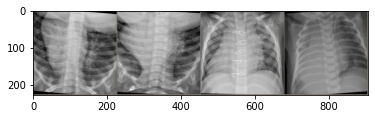

In [23]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

inputs, classes = next(iter(dataloaders['train']))

sample_train_images = torchvision.utils.make_grid(inputs)
imshow(sample_train_images, title=classes)

In [24]:

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [25]:
model_conv = torchvision.models.resnet50(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

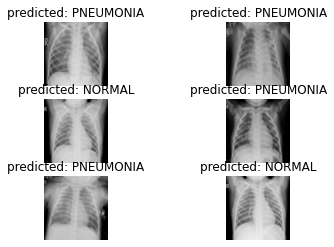

In [26]:
checkpoint = torch.load(CHECK_POINT_PATH)
model_conv.load_state_dict(checkpoint['model_state_dict'])
visualize_model(model_conv)

plt.ioff()
plt.show()

In [27]:
for param in model_conv.parameters():
    param.requires_grad = True

model_conv = model_conv.to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

In [28]:
def apply_test_transforms(inp):
    out = transforms.functional.resize(inp, [224,224])
    out = transforms.functional.to_tensor(out)
    out = transforms.functional.normalize(out, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    return out


chest_xray/val/NORMAL/NORMAL2-IM-1431-0001.jpeg


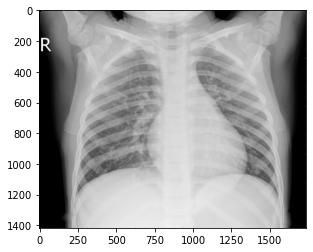

In [41]:
from PIL import Image
import random
import cv2

test_data_dir = f'{data_dir}/val'
test_data_files = os.listdir(test_data_dir)
imgs = os.listdir(f'{test_data_dir}/{test_data_files[0]}')
img_num = random.randint(0, len(imgs))
img_path = f'{test_data_dir}/{test_data_files[0]}/{imgs[img_num]}'
im = Image.open(img_path)
im = im.convert('RGB')
#im = cv2.imread(img_path)
#im = Image.fromarray(im.astype('uint8'), 'RGB')
print(img_path)

plt.imshow(im)

In [42]:
im_as_tensor = apply_test_transforms(im)
print(im_as_tensor.size())
minibatch = torch.stack([im_as_tensor])
print(minibatch.size())
minibatch = minibatch.to(device)

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


In [43]:
model_conv(minibatch)

tensor([[-0.7918,  1.0136]], device='cuda:0', grad_fn=<AddmmBackward>)

In [44]:
softMax = nn.Softmax(dim = 1)
preds = softMax(model_conv(minibatch))
preds

tensor([[0.1412, 0.8588]], device='cuda:0', grad_fn=<SoftmaxBackward>)